# REINFORCE with baseline

이전 장의 CartPole 환경의 {ref}`cartpole-reinforce` 절에서 REINFORCE 에이전트의 학습 곡선이 들쭉 날쭉한 것을 확인할 수 있었다.
심층강화학습은 여러 측면에서 불안정하다고 말을 많이 한다. 그 중 한 가지 측면이 학습 불안정성이다.
학습이 불안정한 이유는 여러 가지가 있을 수 있지만, 가장 대표적인 이유는 식 {eq}`reinforce-policy-gradient`의 그레디언트 추정값 $\hat{g}$의 분산이 크기 때문이다.
분산이 크다는 의미는 에피소드를 진행하여 얻은 $\hat{g}$의 값이 때론 엄청 크고 때론 엄청 작다는 것이다.
분산이 큰 이유는 에피소드를 진행할 때마다 얻게 되는 return $G_t$의 분산이 크기 때문이다.
Return $G_t$의 분산이 큰 이유는 매 에피소드마다 진행되는 양상이 다르기 때문인데, 환경 안에 초기 상태 분포, 정책의 분포, 전이 확률 분포 등 다양한 랜덤성이 존재하기 때문이다.

<br>

---

## Baseline을 이용하여 그레디언트의 분산 줄이기

강화학습에서는 그레디언트 추정량의 분산을 줄이기 위해 베이스라인 (baseline) 방법을 많이 사용한다. 분산이 큰 이유는 몇몇 있겠지만, 가장 단순한 이유는 기댓값 안의 확률변수가 갖는 값의 크기가 크기 때문이다. 베이스라인 방법을 사용하면 기댓값을 바꾸지 않으면서 확률변수가 갖는 값의 크기를 줄여줄 수 있다.

$$
\nabla_{\mathbf{\theta}} J(\mathbf{\theta}) \propto \sum_{s \in \mathcal{S}} d_{\pi_{\mathbf{\theta}}}(s) \sum_{a \in \mathcal{A}} \left( Q^{\pi_{\mathbf{\theta}}}(s,a) - b(s) \right) \nabla_{\mathbf{\theta}} \pi_{\mathbf{\theta}}(a|s),
$$ (policy-gradient-with-baseline)

<br>

여기서 $b(s)$ 행동에 의존적이지 않은 함수가 될 수 있으며, 보통 상태가치함수 $V^{\pi_{\theta}}(s)$이 많이 선택된다. $b(s)$를 빼줬는데도 여전히 비례 관계가 성립하는 이유는 다음과 같이 추가된 항들이 결국 0이기 때문이다.

$$
\begin{matrix}
\sum\limits_a b(s) \nabla_{\mathbf{\theta}}\pi_{\mathbf{\theta}}(a|s) & =&  b(s) \sum\limits_a \nabla_{\mathbf{\theta}}\pi_{\mathbf{\theta}}(a|s) \\
& = & b(s) \nabla_{\mathbf{\theta}} \sum\limits_a \pi_{\mathbf{\theta}}(a|s) \\
& = & b(s) \nabla_{\mathbf{\theta}} 1 \\
& = & 0.
\end{matrix} \quad 
$$

<br>

---

## REINFORCE with baseline

이를 이용하여 $G_t$ 대신 $G_t  - b(s_t)$를 업데이트식에 사용하는 방법을 REINFORCE with baseline이라고 한다.

$$
\mathbf{\theta}_{\text{new}}=\mathbf{\theta}_{\text{old}} + \eta \frac{1}{T} \sum\limits_{t=0}^{T-1}\left(  G_t - b(s_t)\right) \nabla_{\mathbf{\theta}} \log \pi_{\mathbf{\theta}_{\text{old}}}(a_t | s_t).
$$ (reinforce-with-baseline)

<br>

잠시 언급한 것처럼 베이스라인으로 상태가치함수를 많이 사용한다. 하지만 상태가치함수를 직접 계산하기 어렵기 때문에 매개변수를 사용하여 상태가치함수를 모델링하게 된다. 즉, 식 {eq}`reinforce-with-baseline`에서 $b(s_t)$ 대신 $V_{\phi}(s_t)$로 적어줄 수 있다.  이때 $\phi \in \mathbb{R}^{m}$은 상태가치함수 모델의 매개변수이다. 이제 상태가치함수 모델의 매개변수도 업데이트해줘야 하는데 상태가치함수의 정의를 사용하여 업데이트하게 된다. 

```{prf:algorithm} REINFORCE with baseline
:label: REINFORCEwithBaseline

1. 정책 네트워크 $\pi_{\theta}$의 파라미터 $\theta$ 초기화, 가치 네트워크 $V_{\phi}$의 파라미터 $\phi$ 초기화 
2. for _ in range(n_episodes):
3. $\qquad$ $\pi_{\theta}$를 따라 에피소드를 진행하여 $\tau=(s_0, a_0, r_0, s_1, a_1, r_1, \ldots, s_T)$ 수집
4. $\qquad$ for $t=0, 1, 2, \ldots, T-1$:
5. $\qquad\qquad$ $G_t = r_t + \gamma r_{t+1} + \ldots + \gamma^{T-t-1} r_{T-1}$
6. $\qquad\qquad$ $\hat{g}_t = (G_t - V_{\phi}(s_t)) \nabla_{\theta} \log \pi_{\theta} (a_t|s_t)$
7. $\qquad$ $\hat{g} = \frac{1}{T}\sum\limits_{t=0}^{T-1}\hat{g}_{t}$
8. $\qquad$ $\theta \leftarrow \theta + \eta_{\theta} \hat{g}$  $\quad$ `# Gradient ascent`
9. $\qquad$ $\phi \leftarrow \phi - \eta_{\phi} \nabla_{\phi} \frac{1}{T} \sum\limits_{t=0}^{T-1} \left(V_{\phi}(s_t)-G_t \right)^2$  $\quad$ `# Gradient descent with MSE`
```

여기서 주의할 점은 베이스라인을 사용할 경우 정책 $\pi_{\mathbf{\theta}}$와 상태가치함수 $V_{\phi}$ 둘 다 학습하게 되는데, 그렇다고 이를 actor-critic 방법이라고 부르지는 않는다. 무슨 이유에서인지 모르겠지만, 가치함수 훈련을 위한 target 값을 bootstraping을 사용하여 얻을 경우에만 actor-critic이라고 부른다.
REINFORCE with baseline에서는 $V_{\phi}(s_t)$에 대한 타겟값으로 $G_t$를 사용하고 있기 때문에 actor-critic 방법이라고 부르지 않는다.

<br>

---


## REINFORCE with baseline 구현

지난 {ref}`chapter2:reinforce_implementation:title`장에서 이산 행동 공간을 갖는 `CartPole-v1` 환경은 REINFORCE만으로도 잘 제어했으니,
이번 장에서는 연속 행동 공간을 갖는 `Pendulum-v1` 환경만 REINFORCE with baseline으로 제어해보는 실습을 할 것이다. 사용할 패키지는 다음과 같다.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt

from torch.distributions import Normal

<br>

REINFORCE with baseline에는 정책 네트워크와 상태 네트워크가 필요하다. 
히든 레이어 층의 개수와 노드 수 그리고 활성화 함수를 인자로 받을 수 있게 구현을 했지만, 
귀찮으시다면 고정된 크기의 네트워크를 구현해도 좋다.

In [2]:
class MLPGaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPGaussianPolicy, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.mu_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.log_std_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.activation_fn = activation_fn
        
    def forward(self, s):
        s = self.activation_fn(self.input_layer(s))
        for hidden_layer in self.hidden_layers:
            s = self.activation_fn(hidden_layer(s))
            
        mu = self.mu_layer(s)
        log_std = torch.tanh(self.log_std_layer(s))
        
        return mu, log_std.exp()

<br>

상태 가치 함수 네트워크도 MLP이다. 
상태 가치 함수 $V^{\pi}: \mathcal{S} \rightarrow \mathbb{R}$는 상태 1개를 입력 받아서 실수 하나를 출력해주는 함수이다.
따라서 우리의 MLP의 출력 레이어도 실수 1개를 출력해준다. 이를 위해서 출력 레이어는 아무런 활성화 함수를 갖지 않는다.


In [3]:
class MLPStateValue(nn.Module):
    def __init__(self, state_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPStateValue, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.activation_fn = activation_fn
        
    def forward(self, s):
        s = self.activation_fn(self.input_layer(s))
        for hidden_layer in self.hidden_layers:
            s = self.activation_fn(hidden_layer(s))
        s = self.output_layer(s)
        
        return s

<br>

`learn()` 메서드
- `s, a, r, _, _, _ = map(np.stack, zip(*self.buffer))`는 기존 버퍼 안에 $[(s_1, a_1, r_1), (s_2, a_2, r_2), \ldots ]$ 형태로 저장되어 있는 데이터를 $(s_1, s_2, \ldots), (a_1, a_2, \ldots), (r_1, r_2, \ldots)$ 로 변환해준다.
- `z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))`는 torch.atanh(-1.0), torch.atanh(1.0)은 각각 -infty, infty라서 clipping 필요하다.
- `policy_loss = -(log_probs * (ret - v.detach())).mean()`
  - `v`는 가치 네트워크가 출력한 결과이다. 따라서 `policy_loss`를 계산 과정에 만드는데 가치 네트워크의 파라미터도 포함되어 있다.
  - `policy_loss.backward()` 명령시 가치 네트워크의 파라미터에 대해서도 그레디언트를 계산하여 저장한다. 
  - 물론, `policy_optimizer.step()`을 해주기 때문에 정책 네트워크의 파라미터만 업데이트 되겠지만, 불필요한 역전파로 계산 시간을 늘릴 필요는 없다.

In [4]:
class BaselineREINFORCE:
    def __init__(
        self,
        state_dim,
        action_dim,
        gamma=0.99,
        policy_lr=0.0003,
        value_lr=0.0003,
        action_type='continuous'
    ):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPGaussianPolicy(state_dim, action_dim).to(self.device)
        self.value = MLPStateValue(state_dim).to(self.device)
        self.action_type = action_type
        self.gamma = gamma
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=value_lr)
        self.buffer = []

    @torch.no_grad()
    def act(self, s, training=True):
        self.policy.train(training)

        s = torch.as_tensor(s, dtype=torch.float, device=self.device)
        if self.action_type == 'discrete':
            prob = self.policy(s)
            a = torch.multinomial(prob, 1) if training else torch.argmax(prob, dim=-1, keepdim=True)

        else:
            mu, std = self.policy(s)
            z = torch.normal(mu, std) if training else mu
            a = torch.tanh(z)

        return a.cpu().numpy()

    def learn(self):
        self.policy.train()
        # 1 에피소드 동안 모은 데이터 불러오기
        s, a, r, _, _, _ = map(np.stack, zip(*self.buffer))
        s, a, r = map(lambda x: torch.as_tensor(x, dtype=torch.float, device=self.device), [s, a, r])
        r = r.unsqueeze(1)

        # Return G_t 및 log pi(a|s) 만들어주기
        ret = torch.clone(r)
        for t in reversed(range(len(ret) - 1)):
            ret[t] += self.gamma * ret[t + 1]

        if self.action_type == 'discrete':
            probs = self.policy(s)
            log_probs = torch.log(probs.gather(1, a.long()))
        else:
            mu, std = self.policy(s)
            m = Normal(mu, std)
            z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))  # torch.atanh(-1.0), torch.atanh(1.0)은 각각 -infty, infty라서 clipping 필요
            log_probs = m.log_prob(z)

        # 정책 손실함수 만들기 및 역전파
        v = self.value(s)
        policy_loss = -(log_probs * (ret - v.detach())).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        # 상태가치함수 손실함수 만들기 및 역전파
        value_loss = F.mse_loss(v, ret)
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

        result = {'policy_loss': policy_loss.item(), 'value_loss': value_loss.item()}

        return result
    
    def process(self, transition):
        result = None
        self.buffer.append(transition)
        if transition[-1] or transition[-2]:
            result = self.learn()
            self.buffer = []
        return result


<br>

에이전트 구현 이후의 코드는 이전 장과 동일하다.

In [5]:
def evaluate(env_name, agent, eval_iterations):
    env = gym.make(env_name)
    scores = []
    for _ in range(eval_iterations):
        (s, _), terminated, truncated, score = env.reset(seed=np.random.randint(10000)), False, False, 0
        while not (terminated or truncated):
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
            score += r
            s = s_prime
        scores.append(score)
    env.close()
    return round(np.mean(scores), 4)

In [6]:
env_name = 'Pendulum-v1'

seed = 0
max_iterations = 1000000
eval_intervals = 5000
eval_iterations = 10
gamma = 0.9

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = BaselineREINFORCE(state_dim, action_dim, gamma)

logger = []
(s, _), terminated, truncated = env.reset(), False, False
for t in range(1, max_iterations + 1):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(2.0 * a)
    result = agent.process((s, a, r, s_prime, terminated, truncated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
        logger.append([t, 'value_loss', result['value_loss']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, eval_iterations)
        logger.append([t, 'Avg return', score])

<br>

REINFORCE로는 전혀 학습되지 않았던 것과 다르게 baseline을 추가해주니 잘 학습되는 것을 확인할 수 있다. 
랜덤성에 의해 훈련이 안 될 때도 있다. 이때는 커널에 마가 낀 것이니 당황하지 말고 커널 재시작 후 다시 실행하면 된다.

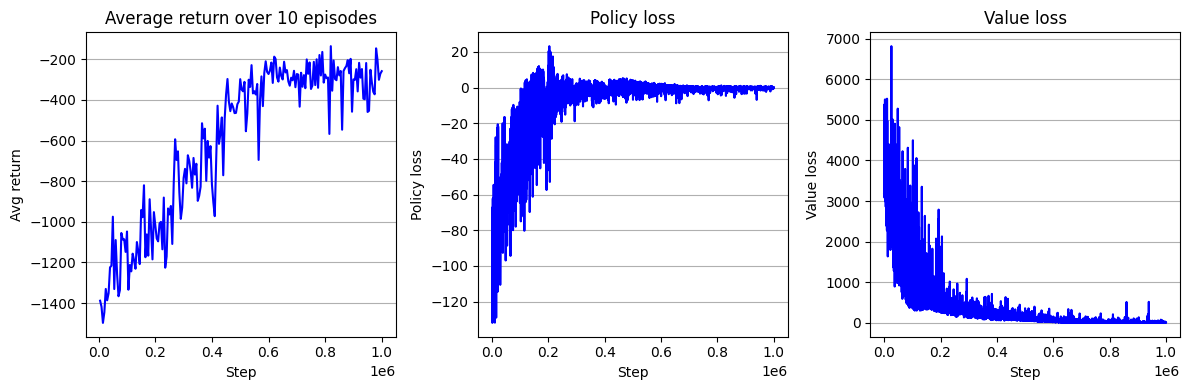

In [7]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 3, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 3, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

ax = fig.add_subplot(1, 3, 3)
key = 'value_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Value loss")
ax.set_xlabel("Step")
ax.set_ylabel("Value loss")

fig.tight_layout()
plt.show()

```{raw} html
<script
   type="text/javascript"
   src="https://utteranc.es/client.js"
   async="async"
   repo="HiddenBeginner/Deep-Reinforcement-Learnings"
   issue-term="pathname"
   theme="github-light"
   label="💬 comment"
   crossorigin="anonymous"
/>
```